In [1]:
import numpy as np
import cv2
import random
import os
import numpy as np
import json
import tqdm
import pycocotools
import glob
import imageio
from torch.utils.data import Dataset, DataLoader
import torchvision
import matplotlib.pyplot as plt
import utils

In [2]:
import torch
import torchvision.transforms as transforms
import torch.utils.data as data
import os
import pickle
import numpy as np
from PIL import Image
from pycocotools.coco import COCO
import torchvision.datasets as dset
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
# from torch import utils

In [3]:
images_path = '/trinity/home/k.gizatullin/gpfs0/agrofield_project/preprocessed_Denmark_05_06_2020/output_batches/'
images_names = glob.glob(images_path + '*.tiff')
print(len(images_names), images_names[100])

6408 /trinity/home/k.gizatullin/gpfs0/agrofield_project/preprocessed_Denmark_05_06_2020/output_batches/3704.tiff


In [4]:
images_names[60]

'/trinity/home/k.gizatullin/gpfs0/agrofield_project/preprocessed_Denmark_05_06_2020/output_batches/5143.tiff'

In [5]:
masks_path = '/trinity/home/k.gizatullin/gpfs0/agrofield_project/preprocessed_Denmark_05_06_2020/output_shapes/'
mask_names = glob.glob(masks_path + images_names[100].split('/')[-1].split('.')[0] + '_*.png')
print(len(mask_names), mask_names[0])

49 /trinity/home/k.gizatullin/gpfs0/agrofield_project/preprocessed_Denmark_05_06_2020/output_shapes/3704_UnknownField_33454.png


In [6]:
image = imageio.imread(images_names[10])

In [7]:
mask = imageio.imread(mask_names[2])
mask.shape

(256, 256)

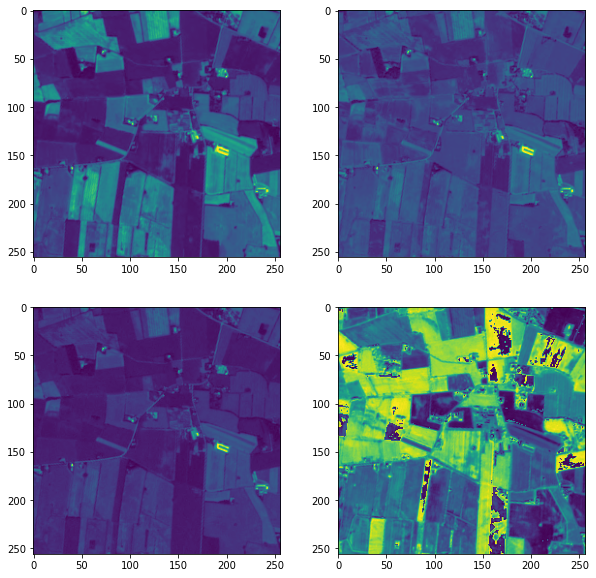

In [8]:
# plt.figure(figsize=(10,10))
fig, axs = plt.subplots(2, 2, constrained_layout=False, figsize=(10,10))

for i, ax in enumerate(axs.flat):
    ax.imshow(image[:,:,i])


In [9]:
np.min(np.where(mask)[1])

100

In [10]:
images_names[100].split('/')[-1].split('.')[0] + '_*.png'

'3704_*.png'

In [11]:
from scipy import ndimage, misc
import cv2

In [12]:
cv2.resize(image, None, fx=2, fy=2).shape

(512, 512, 4)

In [13]:
class field_dataset(Dataset):
    
    def __init__(self, input_batches_path, masks_path, transforms=None, scale_factor=1):
        self.samples_dir = input_batches_path
        self.masks_path = masks_path
        self.transforms = transforms
        self.samples = sorted(glob.glob(self.samples_dir + '*.tiff'))
        self.scale_factor = scale_factor
    
    def __getitem__(self, index):
        image_path = self.samples[index]
        mask_names = glob.glob(masks_path + image_path.split('/')[-1].split('.')[0] + '_*.png')

        image = imageio.imread(image_path)
        image = cv2.resize(image, None, fx=self.scale_factor, fy=self.scale_factor, 
                           interpolation = cv2.INTER_LINEAR)
        ### HARDCODED RGB CHANNELS
        image = image[:,:,:3]
        ### HARDCODED RGB CHANNELS
        boxes = []
        mask = np.zeros((len(mask_names), image.shape[0], 
                         image.shape[1]), dtype=np.uint8)
        for i, mask_filename in enumerate(mask_names):
            buf_mask = imageio.imread(mask_filename)
            buf_mask = cv2.resize(buf_mask, None, fx=self.scale_factor, fy=self.scale_factor, 
                                  interpolation = cv2.INTER_LINEAR)
            mask[i,:,:] = buf_mask.astype(bool).astype(int)
            pos = np.where(mask[i,:,:]>0)
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
#         print(mask_filename)
#         print(len(mask_names))
#         print(image_path)
        num_objs = len(mask_names)
        if num_objs == 0:
                print(index, image_path)
                return None, None
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        
        
        image_id = torch.tensor([index])

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = torch.from_numpy(mask)
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        
        if self.transforms is not None:
            augmented = self.transforms(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        image = torch.from_numpy(image).type(torch.FloatTensor) / 255.0
        image = torch.transpose(image, 0, 2)
#         image = torch.from_numpy(image)
        return image, target
    
    def __len__(self):
        return len(self.samples)

In [14]:
train_dataset = field_dataset(images_path, masks_path, scale_factor=2)

In [15]:
train_dataset[793][1]['boxes'][0].numpy()

array([179.,  55., 208.,  90.], dtype=float32)

In [16]:
train_dataset[793][1]

{'boxes': tensor([[179.,  55., 208.,  90.],
         [321.,   1., 350.,  28.],
         [397.,  45., 454.,  86.],
         [231., 377., 444., 511.],
         [417., 403., 444., 432.],
         [  0., 141.,  16., 186.],
         [231., 107., 282., 146.],
         [  0., 325.,  38., 444.],
         [223., 385., 354., 430.],
         [447., 349., 510., 394.],
         [343.,  99., 460., 158.],
         [ 93., 301., 238., 424.],
         [ 13., 137.,  40., 184.],
         [  0., 507., 150., 511.],
         [351., 477., 444., 511.],
         [373., 197., 466., 340.],
         [207., 267., 390., 346.],
         [479., 229., 506., 354.],
         [159.,  29., 196., 100.],
         [  0., 293.,  18., 336.],
         [199., 335., 270., 390.],
         [201., 153., 300., 286.],
         [  0., 439., 102., 508.],
         [407.,   0., 446.,  36.],
         [ 49., 131.,  78., 170.],
         [287.,   1., 328.,  48.],
         [327.,  69., 464., 112.],
         [245., 153., 398., 282.],
         [1

In [17]:
debug_mask = train_dataset[0][1]['masks'][0].numpy()

In [18]:
np.max(np.where(debug_mask>0)[0])

438

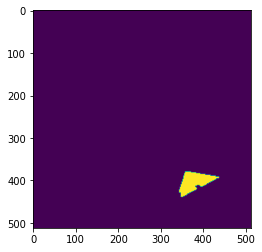

In [19]:
plt.imshow(debug_mask)

In [20]:
# train_dataset[0][1]

In [21]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=4,
                                           collate_fn=utils.collate_fn)

In [22]:
# for batch_number, data in enumerate(train_loader):
#     pass

In [23]:
# batch_number

In [24]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4,
                                           collate_fn=utils.collate_fn)

In [25]:
# batch_number

In [26]:
# data[1][0]['image_id']

In [27]:
# print(batch_number)

In [28]:
# next(iter(train_loader))[1]

In [29]:
from torchsummary import summary

In [31]:
num_classes = 2
# load an instance segmentation model pre-trained on COCO
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)


In [32]:
model.backbone.body.conv1.stride = (1,1)
model.backbone.body.layer2[0].conv2.stride = (1,1)
model.backbone.body.layer2[0].downsample[0].stride = (1,1)

In [33]:
# model

In [34]:
# model.eval()
# summary(model, (3, 512, 512))

In [35]:
# summary(your_model, input_size=(channels, H, W))

In [36]:
# # get the number of input features for the classifier
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# # replace the pre-trained head with a new one
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# # now get the number of input features for the mask classifier
# in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
# hidden_layer = 256
# # and replace the mask predictor with a new one
# model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
#                                                    hidden_layer,
#                                                    num_classes)

In [30]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [31]:
# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [32]:
anchor_sizes = ((8,), (12,), (16,), (24,), (32,))
aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)

In [36]:
from torchvision.models.detection import FasterRCNN
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [37]:
FastRCNNPredictor?

Init signature: FastRCNNPredictor(in_channels, num_classes)
Docstring:     
Standard classification + bounding box regression layers
for Fast R-CNN.

Arguments:
    in_channels (int): number of input channels
    num_classes (int): number of output classes (including background)
Init docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.
File:           /home/k.gizatullin/.conda/pytorch_gpu_clone/lib/python3.7/site-packages/torchvision/models/detection/faster_rcnn.py
Type:           type
Subclasses:     


In [38]:
MaskRCNNPredictor?

Init signature: MaskRCNNPredictor(in_channels, dim_reduced, num_classes)
Docstring:     
A sequential container.
Modules will be added to it in the order they are passed in the constructor.
Alternatively, an ordered dict of modules can also be passed in.

To make it easier to understand, here is a small example::

    # Example of using Sequential
    model = nn.Sequential(
              nn.Conv2d(1,20,5),
              nn.ReLU(),
              nn.Conv2d(20,64,5),
              nn.ReLU()
            )

    # Example of using Sequential with OrderedDict
    model = nn.Sequential(OrderedDict([
              ('conv1', nn.Conv2d(1,20,5)),
              ('relu1', nn.ReLU()),
              ('conv2', nn.Conv2d(20,64,5)),
              ('relu2', nn.ReLU())
            ]))
Init docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.
File:           /home/k.gizatullin/.conda/pytorch_gpu_clone/lib/python3.7/site-packages/torchvision/models/detection/mask_rcnn.py
T

In [39]:
rpn_anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)
model = torchvision.models.detection.maskrcnn_resnet50_fpn(roi_pooler=roi_pooler, rpn_anchor_generator=rpn_anchor_generator, pretrained=False)


TypeError: __init__() got an unexpected keyword argument 'roi_pooler'

In [41]:
box_predictor = FastRCNNPredictor(in_features, num_classes)

In [48]:


def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
#     model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    rpn_anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(rpn_anchor_generator=rpn_anchor_generator, pretrained=False)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 64
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [49]:
get_instance_segmentation_model(2)

MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
    

In [102]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        pass
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
#         transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [103]:
import pycocotools

In [104]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)



MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
    

In [105]:
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.005,
#                             momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.Adam(params, lr=0.001)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=1,
                                               gamma=0.6)

In [106]:
import pycocotools

In [107]:
torch.version.cuda

'10.1'

In [108]:
from torch.utils.cpp_extension import CUDA_HOME; print(CUDA_HOME)

/gpfs/data/opt/cuda-10.1


In [109]:
# from tools.setup_helpers.cuda import CUDA_HOME; print(CUDA_HOME)

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
#     evaluate(model, data_loader_test, device=device)

In [ ]:
# let's train it for 10 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
#     evaluate(model, data_loader_test, device=device)

Epoch: [0]  [   0/1602]  eta: 12:46:23  lr: 0.000002  loss: 3.2104 (3.2104)  loss_classifier: 0.6842 (0.6842)  loss_box_reg: 0.0002 (0.0002)  loss_mask: 0.7480 (0.7480)  loss_objectness: 0.6925 (0.6925)  loss_rpn_box_reg: 1.0855 (1.0855)  time: 28.7041  data: 23.9898  max mem: 3391
Epoch: [0]  [  10/1602]  eta: 3:32:58  lr: 0.000012  loss: 3.6228 (3.5832)  loss_classifier: 0.6490 (0.6404)  loss_box_reg: 0.0002 (0.0003)  loss_mask: 0.6758 (0.6694)  loss_objectness: 0.6906 (0.6907)  loss_rpn_box_reg: 1.6587 (1.5823)  time: 8.0269  data: 6.3551  max mem: 4726
Epoch: [0]  [  20/1602]  eta: 3:15:50  lr: 0.000022  loss: 3.5914 (3.5035)  loss_classifier: 0.5441 (0.5350)  loss_box_reg: 0.0003 (0.0010)  loss_mask: 0.6361 (0.6531)  loss_objectness: 0.6887 (0.6861)  loss_rpn_box_reg: 1.6651 (1.6284)  time: 6.3635  data: 5.0276  max mem: 4726
Epoch: [0]  [  30/1602]  eta: 3:01:41  lr: 0.000032  loss: 3.1439 (3.3624)  loss_classifier: 0.3672 (0.4780)  loss_box_reg: 0.0031 (0.0038)  loss_mask: 0.610

In [ ]:
evaluate(model, train_loader, device=device)

In [ ]:
torch.save(model.state_dict(), 'pytorch_model_test_upscaled.pth')

In [ ]:
# pick one image from the test set
img, _ = train_dataset[40]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [ ]:
prediction[0]['masks'].shape

In [ ]:
plt.figure(figsize=(9,9))
plt.imshow(img.mul(255).permute(1, 2, 0).byte().numpy())

In [ ]:
plt.figure(figsize=(9,9))
plt.imshow(prediction[0]['masks'][10, 0].mul(255).byte().cpu().numpy())

In [ ]:
# prediction[0]['boxes'] - prediction_2['boxes']

In [ ]:
torch.mean(prediction[0]['masks'] - prediction_2['masks'])

In [ ]:
# prediction_2

In [ ]:
# let's train it for 10 epochs
num_epochs = 10

# for epoch in range(num_epochs):
#     # train for one epoch, printing every 10 iterations
#     train_one_epoch(model, optimizer, test_json_loader, device, epoch, print_freq=10)
#     # update the learning rate
#     lr_scheduler.step()
#     # evaluate on the test dataset
# #     evaluate(model, data_loader_test, device=device)

# for epoch in range(num_epochs):
#     model.train()
#     i = 0    
#     for imgs, annotations in train_loader:
#         i += 1
#         imgs = list(img.to(device) for img in imgs)
# #         annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
#         annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
#         loss_dict = model(imgs, annotations)
#         losses = sum(loss for loss in loss_dict.values())

#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()

#         print(f'Iteration: {i}/{len(train_loader)}, Loss: {losses}')

In [ ]:
annotations[0]